# Code Progress for Identifying Presence or Absence of Seismic Facies in Seismic Images Using Deep Learning



In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Nov  2 22:00:05 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import files

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import math
from scipy.signal.windows import triang
from scipy.signal import convolve2d as conv2

from tqdm.notebook import tqdm #progress bar

import cv2

import datetime

import tensorflow as tf
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

from sklearn.model_selection import train_test_split

from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
#drive = GoogleDrive()

In [3]:
data_train_parihaka = np.load('/content/drive/MyDrive/Dataset /data_train.npz',  
               allow_pickle=True, mmap_mode = 'r')['data']


label_train_parihaka = np.load('/content/drive/MyDrive/Dataset /labels_train.npz',  
               allow_pickle=True, mmap_mode = 'r')['labels']

### Data Preprocessing 
#### Loading in Dataset 1 (Parihaka)

In [4]:
print('Shape X:', data_train_parihaka.shape)
print('Shape Y:', label_train_parihaka.shape)

Shape X: (1006, 782, 590)
Shape Y: (1006, 782, 590)


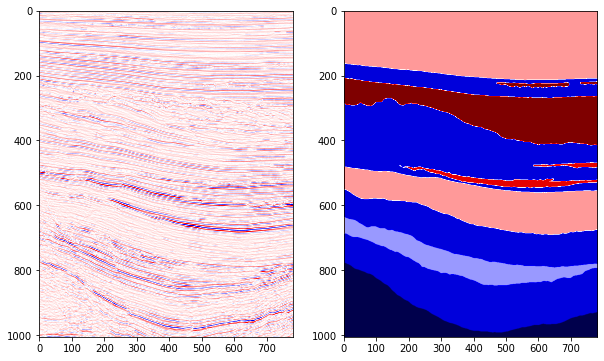

In [5]:
fig, ax = plt.subplots(1,2, figsize=(10,8))

ax[0].imshow(data_train_parihaka[:,:,200], cmap='seismic')
ax[1].imshow(label_train_parihaka[:,:,200], cmap='seismic')

#### Loading Dataset 2 (Netherlands F3 Block) 
##### We will use this one for transfer learning once we have trustworthy weights. 

In [6]:
data_train_netherlands = np.load('/content/drive/MyDrive/Dataset /Dataset_2/train_seismic.npy')


label_train_netherlands = np.load('/content/drive/MyDrive/Dataset /Dataset_2/train_labels.npy')

In [7]:
print('Shape X:', data_train_netherlands.shape)
print('Shape Y:', label_train_netherlands.shape)

Shape X: (401, 701, 255)
Shape Y: (401, 701, 255)


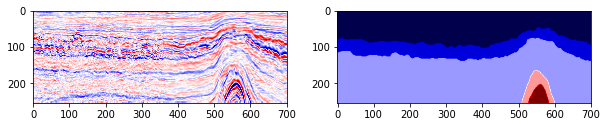

In [8]:
fig, ax = plt.subplots(1,2, figsize=(10,8))

ax[0].imshow(data_train_netherlands[400,:,:].T, cmap='seismic')
ax[1].imshow(label_train_netherlands[400,:,:].T, cmap='seismic')

In [9]:
data_test1_netherlands = np.load('/content/drive/MyDrive/Dataset /Dataset_2/test1_seismic.npy')


label_test1_netherlands= np.load('/content/drive/MyDrive/Dataset /Dataset_2/test1_labels.npy')

In [10]:
print('Shape X:', data_test1_netherlands.shape)
print('Shape Y:', label_test1_netherlands.shape)

Shape X: (200, 701, 255)
Shape Y: (200, 701, 255)


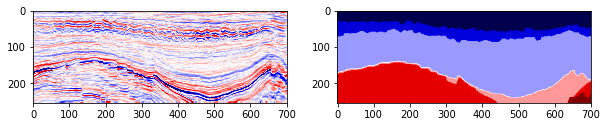

In [11]:
fig, ax = plt.subplots(1,2, figsize=(10,8))

ax[0].imshow(data_test1_netherlands[20,:,:].T, cmap='seismic')
ax[1].imshow(label_test1_netherlands[20,:,:].T, cmap='seismic')

## Implement Data Preprocessing 

### Gain + RMS

In [12]:
def gain(data,dt,parameters):
    nt,nx = data.shape
    dout = np.zeros(data.shape)
    L = parameters/dt+1
    L = np.floor(L/2)
    h = triang(2*L+1)
    shaped_h  = h.reshape(len(h),1)
    for k in range(nx):
        aux = data[:,k]
        e = aux**2
        shaped_e = e.reshape(len(e),1)
        rms = np.sqrt(conv2(shaped_e,shaped_h,"same"))
        epsi = 1e-10*max(rms)
        op = rms/(rms**2+epsi)
        op = op.reshape(len(op),)
        dout[:,k] = data[:,k]*op
    for k in range(nx):
        aux = dout[:,k]
        amax = np.sqrt(sum(aux**2)/nt)
        dout[:,k] = dout[:,k]/amax
    return dout

In [13]:
test_image=data_train_parihaka[:,200,:]
test_gain =gain(test_image,3e-3,0.8)

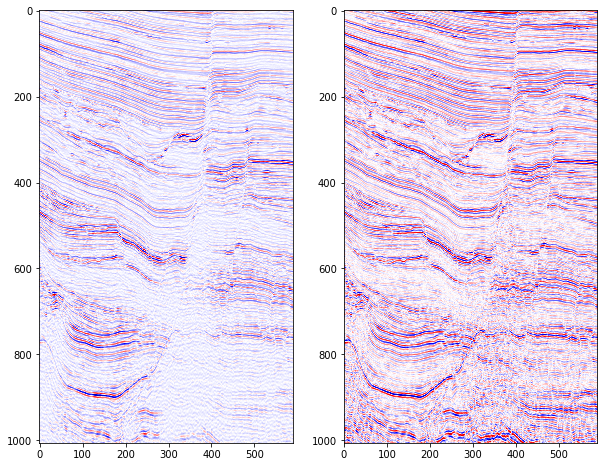

In [14]:
fig, ax = plt.subplots(1,2, figsize=(10,8))

ax[0].imshow(data_train_parihaka[:,200,:], cmap='seismic')
ax[1].imshow(test_gain, cmap='seismic')

In [15]:
# load in an RMS processed dataset
data_train_parihaka_pp = np.load('/content/drive/MyDrive/Dataset /data_train_processed.npz',  
               allow_pickle=True, mmap_mode = 'r')['data']

2-D Image Making

In [16]:
training_img_data = []
training_label_data = []

for i in tqdm(range(0, 580)): #reshaping the images into appropriate sizes 
  img = data_train_parihaka_pp[:, :, i] 
  label = label_train_parihaka[:, :, i]

  img = np.expand_dims(img, axis=2).astype('float32')
  label = np.expand_dims(label, axis=2).astype('float32')

  img = cv2.resize(img, (128, 128))
  label = cv2.resize(label, (128, 128))

  img = img/np.amax(img)
  img = np.clip(img, 0, 255)
  img = (img*255).astype(int)

  img = img/255.

  img = cv2.merge([img,img,img])

  training_img_data.append(img) 
  training_label_data.append(label)
  

  0%|          | 0/580 [00:00<?, ?it/s]

In [17]:
print('Before Data Reshape', np.array(data_train_parihaka_pp).shape)
print('After Data Reshape', np.array(training_img_data).shape)

print('Before Target Reshape', np.array(label_train_parihaka).shape)
print('After Target Reshape', np.array(training_label_data).shape)

Before Data Reshape (1006, 782, 590)
After Data Reshape (580, 128, 128, 3)
Before Target Reshape (1006, 782, 590)
After Target Reshape (580, 128, 128)


In [18]:
training_img_data = np.asarray(training_img_data)

training_label_data = np.asarray(training_label_data)

print(training_label_data.shape)

(580, 128, 128)


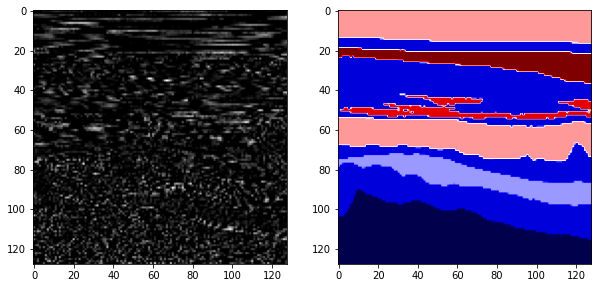

In [19]:

fig, ax = plt.subplots(1,2, figsize=(10,8))

ax[0].imshow(training_img_data[0,:,:,:], cmap='seismic')
ax[1].imshow(training_label_data[0,:,:], cmap='seismic')

In [20]:
# Augmentation
datagen = ImageDataGenerator(horizontal_flip = True, shear_range = 0.2, zoom_range = 0.2)
datagen_test = ImageDataGenerator(horizontal_flip = True)

datagen.fit(training_img_data)

## Processing F3 Data

In [21]:
training_img_data_f3 = []
training_label_data_f3 = []

for i in tqdm(range(0, 401)): #reshaping the images into appropriate sizes 
  img = data_train_netherlands[i, :, :].T
  label = label_train_netherlands[i, :, :].T

  img = np.expand_dims(img, axis=2).astype('float32')
  label = np.expand_dims(label, axis=2).astype('float32')

  img = cv2.resize(img, (128, 128))
  label = cv2.resize(label, (128, 128))

  img = img/np.amax(img)
  img = np.clip(img, 0, 255)
  img = (img*255).astype(int)

  img = img/255.

  img = cv2.merge([img,img,img])

  training_img_data_f3.append(img) 
  training_label_data_f3.append(label)

  0%|          | 0/401 [00:00<?, ?it/s]

In [22]:
test1_img_data_f3 = []
test1_label_data_f3 = []

for i in tqdm(range(0, 200)): #reshaping the images into appropriate sizes 
  img = data_test1_netherlands[i, :, :].T 
  label = label_test1_netherlands[i, :, :].T

  img = np.expand_dims(img, axis=2).astype('float32')
  label = np.expand_dims(label, axis=2).astype('float32')

  img = cv2.resize(img, (128, 128))
  label = cv2.resize(label, (128, 128))

  img = img/np.amax(img)
  img = np.clip(img, 0, 255)
  img = (img*255).astype(int)

  img = img/255.

  img = cv2.merge([img,img,img])

  test1_img_data_f3.append(img) 
  test1_label_data_f3.append(label)

  0%|          | 0/200 [00:00<?, ?it/s]

In [23]:
training_img_data_f3 = np.asarray(training_img_data_f3)

training_label_data_f3 = np.asarray(training_label_data_f3)

test1_img_data_f3 = np.asarray(test1_img_data_f3)

test1_label_data_f3 = np.asarray(test1_label_data_f3)


print('Converted F3 Dims:', training_img_data_f3.shape)
print('Converted F3 Dims (Test):', test1_img_data_f3.shape)

Converted F3 Dims: (401, 128, 128, 3)
Converted F3 Dims (Test): (200, 128, 128, 3)


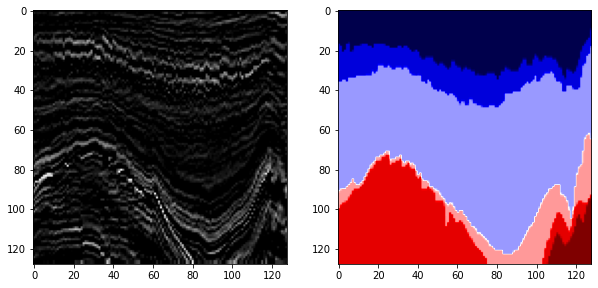

In [24]:
fig, ax = plt.subplots(1,2, figsize=(10,8))

ax[0].imshow(test1_img_data_f3[20,:,:,:], cmap='seismic')
ax[1].imshow(test1_label_data_f3[100,:,:], cmap='seismic')

In [25]:
# Augmentation
datagen_f3 = ImageDataGenerator(horizontal_flip = True, shear_range = 0.2, zoom_range = 0.2)

datagen_f3.fit(training_img_data_f3)

Developing the Model Using Keras API

Attempt #1: U-Net without Augmentation

In [26]:
ACTIVATION = 'relu'
ACTIVATION_OUT = 'softmax'
initializer = 'he_normal'
input_size = np.array(training_img_data).shape[1:]
N_classes = 7


In [27]:
def UNet1(input_size, N_CLASSES, activation_name, initialization_name, DropoutRatio = 0.5): 
  # Encoder

  # Block encoder 1
  inputs = Input(shape=input_size)
  #data_augmentation
  conv_enc_1 = Conv2D(64, 3, activation = ACTIVATION, padding='same', kernel_initializer=initializer)(inputs)
  conv_enc_1 = BatchNormalization()(conv_enc_1)
  conv_enc_1 = Conv2D(64, 3, activation = ACTIVATION, padding='same', kernel_initializer=initializer)(conv_enc_1)
  conv_enc_1 = BatchNormalization()(conv_enc_1)
  conv_enc_1 = Activation(ACTIVATION)(conv_enc_1)

  # Block encoder 2
  max_pool_enc_2 = MaxPooling2D(pool_size=(2, 2))(conv_enc_1)
  max_pool_enc_2 = Dropout(DropoutRatio/2)(max_pool_enc_2)
  conv_enc_2 = Conv2D(128, 3, activation = ACTIVATION, padding = 'same', kernel_initializer = initializer)(max_pool_enc_2)
  conv_enc_2 = BatchNormalization()(conv_enc_2)
  conv_enc_2 = Conv2D(128, 3, activation = ACTIVATION, padding = 'same', kernel_initializer = initializer)(conv_enc_2)
  conv_enc_2 = BatchNormalization()(conv_enc_2)
  conv_enc_2 = Activation(ACTIVATION)(conv_enc_2)

  # Block  encoder 3
  max_pool_enc_3 = MaxPooling2D(pool_size=(2, 2))(conv_enc_2)
  max_pool_enc_3 = Dropout(DropoutRatio)(max_pool_enc_3)
  conv_enc_3 = Conv2D(256, 3, activation = ACTIVATION, padding = 'same', kernel_initializer = initializer)(max_pool_enc_3)
  conv_enc_3 = BatchNormalization()(conv_enc_3)
  conv_enc_3 = Conv2D(256, 3, activation = ACTIVATION, padding = 'same', kernel_initializer = initializer)(conv_enc_3)
  conv_enc_3 = BatchNormalization()(conv_enc_3)
  conv_enc_3 = Activation(ACTIVATION)(conv_enc_3)

  # Block  encoder 4
  max_pool_enc_4 = MaxPooling2D(pool_size=(2, 2))(conv_enc_3)
  max_pool_enc_4 = Dropout(DropoutRatio)(max_pool_enc_4)
  conv_enc_4 = Conv2D(512, 3, activation = ACTIVATION, padding = 'same', kernel_initializer = initializer)(max_pool_enc_4)
  conv_enc_4 = BatchNormalization()(conv_enc_4)
  conv_enc_4 = Conv2D(512, 3, activation = ACTIVATION, padding = 'same', kernel_initializer = initializer)(conv_enc_4)
  conv_enc_4 = BatchNormalization()(conv_enc_4)
  conv_enc_4 = Activation(ACTIVATION)(conv_enc_4)
  #

  # ----------- #
  maxpool = MaxPooling2D(pool_size=(2, 2))(conv_enc_4)
  maxpool = Dropout(DropoutRatio)(maxpool)
  conv = Conv2D(1024, 3, activation = ACTIVATION, padding = 'same', kernel_initializer = initializer)(maxpool)
  conv = BatchNormalization()(conv)
  conv = Conv2D(1024, 3, activation = ACTIVATION, padding = 'same', kernel_initializer = initializer)(conv)
  conv = BatchNormalization()(conv)
  conv = Activation(ACTIVATION)(conv)

  # ----------- #

  # Decoder

  # Block decoder 1
  up_dec_1 = Conv2D(512, 2, activation = ACTIVATION, padding = 'same', kernel_initializer = initializer)(UpSampling2D(size = (2,2))(conv))
  merge_dec_1 = concatenate([conv_enc_4, up_dec_1], axis = 3)
  merge_dec_1 = Dropout(DropoutRatio)(merge_dec_1)
  conv_dec_1 = Conv2D(512, 3, activation = ACTIVATION, padding = 'same', kernel_initializer = initializer)(merge_dec_1)
  conv_dec_1 = BatchNormalization()(conv_dec_1)
  conv_dec_1 = Conv2D(512, 3, activation = ACTIVATION, padding = 'same', kernel_initializer = initializer)(conv_dec_1)
  conv_dec_1 = BatchNormalization()(conv_dec_1)
  conv_dec_1 = Activation(ACTIVATION)(conv_dec_1)

  # Block decoder 2
  up_dec_2 = Conv2D(256, 2, activation = ACTIVATION, padding = 'same', kernel_initializer = initializer)(UpSampling2D(size = (2,2))(conv_dec_1))
  merge_dec_2 = concatenate([conv_enc_3, up_dec_2], axis = 3)
  merge_dec_2 = Dropout(DropoutRatio)(merge_dec_2)
  conv_dec_2 = Conv2D(256, 3, activation = ACTIVATION, padding = 'same', kernel_initializer = initializer)(merge_dec_2)
  conv_dec_2 = BatchNormalization()(conv_dec_2)
  conv_dec_2 = Conv2D(256, 3, activation = ACTIVATION, padding = 'same', kernel_initializer = initializer)(conv_dec_2)
  conv_dec_2 = BatchNormalization()(conv_dec_2)
  conv_dec_2 = Activation(ACTIVATION)(conv_dec_2)

  # Block decoder 3
  up_dec_3 = Conv2D(128, 2, activation = ACTIVATION, padding = 'same', kernel_initializer = initializer)(UpSampling2D(size = (2,2))(conv_dec_2))
  merge_dec_3 = concatenate([conv_enc_2, up_dec_3], axis = 3)
  merge_dec_3 = Dropout(DropoutRatio)(merge_dec_3)
  conv_dec_3 = Conv2D(128, 3, activation = ACTIVATION, padding = 'same', kernel_initializer = initializer)(merge_dec_3)
  conv_dec_3 = BatchNormalization()(conv_dec_3)
  conv_dec_3 = Conv2D(128, 3, activation = ACTIVATION, padding = 'same', kernel_initializer = initializer)(conv_dec_3)
  conv_dec_3 = BatchNormalization()(conv_dec_3)
  conv_dec_3 = Activation(ACTIVATION)(conv_dec_3)

  # Block decoder 4
  up_dec_4 = Conv2D(64, 2, activation = ACTIVATION, padding = 'same', kernel_initializer = initializer)(UpSampling2D(size = (2,2))(conv_dec_3))
  merge_dec_4 = concatenate([conv_enc_1, up_dec_4], axis = 3)
  merge_dec_4 = Dropout(DropoutRatio)(merge_dec_4)
  conv_dec_4 = Conv2D(64, 3, activation = ACTIVATION, padding = 'same', kernel_initializer = initializer)(merge_dec_4)
  conv_dec_4 = BatchNormalization()(conv_dec_4)
  conv_dec_4 = Conv2D(64, 3, activation = ACTIVATION, padding = 'same', kernel_initializer = initializer)(conv_dec_4)
  conv_dec_4 = BatchNormalization()(conv_dec_4)
  conv_dec_4 = Activation(ACTIVATION)(conv_dec_4)

  #last = tf.keras.layers.Conv2DTranspose(1, 3, strides=1, padding='same')(conv_dec_4) 
  output = Conv2D(N_CLASSES, 1, activation = ACTIVATION_OUT)(conv_dec_4)

  # pred_mask = tf.argmax(output, axis=-1)
  # # pred_mask becomes [IMG_SIZE, IMG_SIZE]
  # # but matplotlib needs [IMG_SIZE, IMG_SIZE, 1]
  # pred_mask = tf.expand_dims(pred_mask, axis=-1)
  # pred_mask = tf.cast(pred_mask, tf.int64)
   # Lets create the model. Here we initialize the Keras model instance. We use this later to train/test. 
  
  model = tf.keras.Model(inputs = inputs, outputs = output)

  return inputs, output

#### Create the Model

In [ ]:
inputs, output = UNet1(input_size, N_CLASSES = N_classes, activation_name = ACTIVATION, initialization_name= initializer)

pari_model_unet = tf.keras.Model(inputs = inputs, outputs = output)

print(pari_model_unet.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                           

#### Compile the Model

Add in our optimizers. We will start with ADAM and binary cross-entropy.

In [ ]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f**2) + K.sum(y_pred_f**2) + 1)

def dice_loss(y_true,y_pred):
    return 1-dice_coef(y_true,y_pred)

def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [ ]:
model_path="{}.h5".format('fixed_model_unet_1') #hdf5
checkpoint = ModelCheckpoint(model_path, monitor='val_loss', verbose=1,save_best_only=True, mode='min', save_weights_only = False)

In [ ]:
pari_model_unet.compile(optimizer=Adam(learning_rate=0.0001), loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy' , dice_coef])

Visualize a Sample Prediction

In [ ]:
print(training_img_data.shape)
print(training_label_data.shape)

(580, 128, 128, 3)
(580, 128, 128)


In [ ]:

x_train, x_valid, y_train, y_valid = train_test_split(training_img_data, training_label_data,test_size=0.2, shuffle= True)

In [ ]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_images=True, update_freq='batch')

#tf.cast(training_label_data, tf.float32)
#model_history = pari_model_unet.fit(training_img_data, training_label_data, validation_split=0.2, epochs=50, callbacks=[tensorboard_callback])
model_history = pari_model_unet.fit(datagen.flow(x_train, y_train), validation_data=(x_valid, y_valid), epochs=100, callbacks=[tensorboard_callback, checkpoint])

Epoch 1/100
15/15 [==============================] - ETA: 0s - loss: 2.0573 - accuracy: 0.2450
Epoch 00001: val_loss improved from inf to 1.94331, saving model to fixed_model_unet_1.h5
15/15 [==============================] - 45s 1s/step - loss: 2.0573 - accuracy: 0.2450 - val_loss: 1.9433 - val_accuracy: 0.2782
Epoch 2/100
15/15 [==============================] - ETA: 0s - loss: 1.7385 - accuracy: 0.3871
Epoch 00002: val_loss improved from 1.94331 to 1.61575, saving model to fixed_model_unet_1.h5
15/15 [==============================] - 15s 1s/step - loss: 1.7385 - accuracy: 0.3871 - val_loss: 1.6157 - val_accuracy: 0.5776
Epoch 3/100
15/15 [==============================] - ETA: 0s - loss: 1.2601 - accuracy: 0.5670
Epoch 00003: val_loss did not improve from 1.61575
15/15 [==============================] - 13s 889ms/step - loss: 1.2601 - accuracy: 0.5670 - val_loss: 7.2977 - val_accuracy: 0.5557
Epoch 4/100
15/15 [==============================] - ETA: 0s - loss: 0.9923 - accuracy: 0.

In [ ]:
def PlotHistory(_model, feature, start_epoch = 0, path_file = None):
    val = "val_" + feature
    
    plt.xlabel('Epoch Number - ' + str(start_epoch))
    plt.ylabel(feature)
    plt.plot(_model.history[feature][start_epoch:])
    plt.plot(_model.history[val][start_epoch:])
    plt.title(val)
    plt.legend(["train_"+feature, val])   

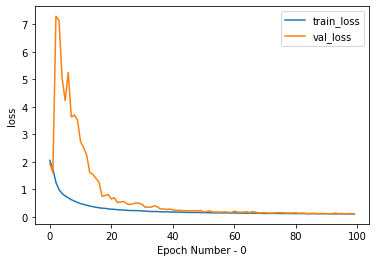

In [ ]:
PlotHistory(model_history, 'loss')

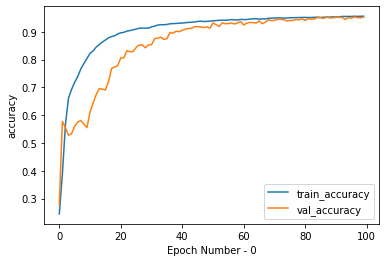

In [ ]:
PlotHistory(model_history, 'accuracy')

In [ ]:
pred_test = pari_model_unet.predict(training_img_data)
print(pred_test.shape)
pred_mask = tf.argmax(pred_test, axis=-1)
  # # pred_mask becomes [IMG_SIZE, IMG_SIZE]
  # # but matplotlib needs [IMG_SIZE, IMG_SIZE, 1]
pred_mask = tf.expand_dims(pred_mask, axis=-1)
print(pred_mask.shape)

(580, 128, 128, 7)
(580, 128, 128, 1)


[[[[1.15084723e-02 1.21051390e-02 1.16723767e-02 ... 9.19940114e-01
    1.89454630e-02 1.36038223e-02]
   [7.53825181e-04 7.37932278e-04 4.11382469e-04 ... 9.94191825e-01
    2.23974185e-03 7.87498662e-04]
   [2.16301443e-04 2.05827222e-04 7.90479389e-05 ... 9.98491883e-01
    6.39243808e-04 1.41818367e-04]
   ...
   [4.70527477e-04 4.12964524e-04 2.39005065e-04 ... 9.97348189e-01
    7.93736952e-04 2.62505957e-04]
   [7.19882082e-04 1.07795524e-03 6.26620313e-04 ... 9.95152712e-01
    1.09606620e-03 4.80713847e-04]
   [9.19613894e-03 1.54854786e-02 6.46004779e-03 ... 9.44290757e-01
    6.90537365e-03 6.24601915e-03]]

  [[2.10788287e-03 1.67507923e-03 1.18211471e-03 ... 9.87314820e-01
    3.31741618e-03 1.67330389e-03]
   [2.05005650e-04 1.52691107e-04 3.95625757e-05 ... 9.98610139e-01
    4.96462279e-04 1.18410106e-04]
   [4.55287591e-05 4.21661280e-05 5.27362863e-06 ... 9.99647379e-01
    1.49397834e-04 2.22855833e-05]
   ...
   [9.04497720e-05 5.25342621e-05 1.22733081e-05 ... 9.99

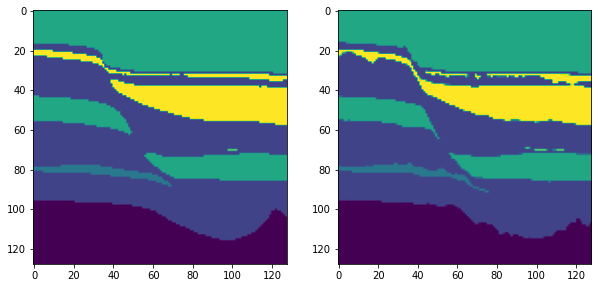

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,8))

ax[0].imshow(pred_mask[400, :, :, 0])
ax[1].imshow(training_label_data[400, :, :])

print(pred_test)

Importing the Test Data

In [ ]:
data_test_parihaka_1 = np.load('/content/drive/MyDrive/Dataset /data_test_1.npz')


data_test_parihaka_2 = np.load('/content/drive/MyDrive/Dataset /data_test_2.npz')

data_test_parihaka_1 = data_test_parihaka_1['data']
data_test_parihaka_2 = data_test_parihaka_2['data']

(1006, 782, 251)


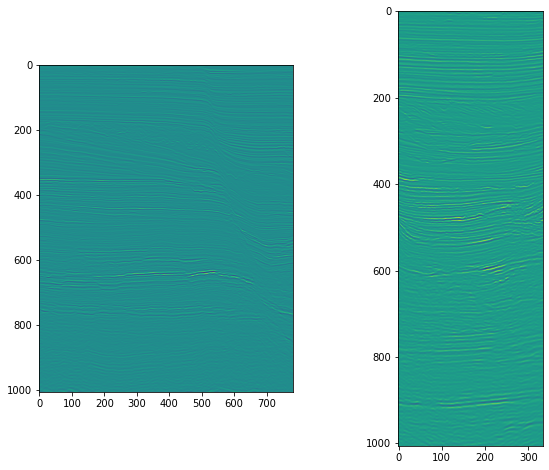

In [ ]:
# Plot our test data examples
fig, ax = plt.subplots(1,2, figsize=(10,8))

ax[0].imshow(data_test_parihaka_1[:,:,1])
ax[1].imshow(data_test_parihaka_2[:,:,1])

print(data_test_parihaka_1.shape)

In [ ]:
testing_img_data_1 = []
testing_img_data_2 = []

def preprocess_input(data_in, data_out, axis):
  for i in range(0, axis):
    img = data_in[:, :, i]
    img = np.expand_dims(img, axis=2).astype('float32')
    

    img = cv2.resize(img, (128, 128))

    img = img/np.amax(img)
    img = np.clip(img, 0, 255)
    img = (img*255).astype(int)
    img = cv2.merge([img,img,img])

    data_out.append(img)

  return data_out

testing_img_data_1 = preprocess_input(data_test_parihaka_1, testing_img_data_1, 251)
testing_img_data_2 = preprocess_input(data_test_parihaka_2, testing_img_data_2, 251)

In [ ]:
testing_img_data_1 = np.asarray(testing_img_data_1)
testing_img_data_2 = np.asarray(testing_img_data_2)

In [ ]:
testing_img_data_1.shape

(251, 128, 128, 3)

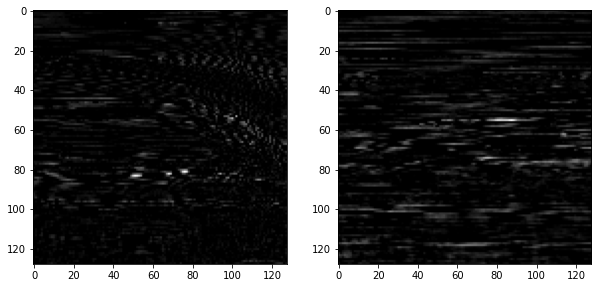

In [ ]:
# Plot our test data examples
fig, ax = plt.subplots(1,2, figsize=(10,8))

ax[0].imshow(testing_img_data_1[100,:,:,:])
ax[1].imshow(testing_img_data_2[100,:,:,:])

In [ ]:
pred_test_data_pari = pari_model_unet.predict(testing_img_data_1)

print(pred_test_data_pari.shape)
pred_mask_test_pari = tf.argmax(pred_test_data_pari, axis=-1)
  # # pred_mask becomes [IMG_SIZE, IMG_SIZE]
  # # but matplotlib needs [IMG_SIZE, IMG_SIZE, 1]
pred_mask_test_pari = tf.expand_dims(pred_mask_test_pari, axis=-1)
print(pred_mask_test_pari.shape)


(251, 128, 128, 7)
(580, 128, 128, 1)


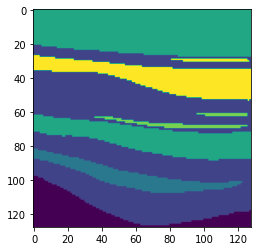

In [ ]:
plt.imshow(pred_mask_test_pari[200, :, :, 0])

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,8))

ax[0].imshow(pred_mask_test_pari[4, :, :, 0])
ax[0].set_xlabel('X (km)')
ax[0].set_ylabel('Time (s)')
ax[0].set_title('Predicted Facies')
fig.suptitle('Prediction with Test (Parihaka)')

# Transfer Learning with U-Net 

In [ ]:
base_model = tf.keras.models.load_model('/content/drive/MyDrive/Dataset /fixed_model_unet_1.h5')

In [ ]:
# for layer in base_model.layers:
#   layer.trainable = False

for layer in base_model.layers[:69]:
   layer.trainable = False
for layer in base_model.layers[69:]:
   layer.trainable = True

In [ ]:
N_CLASSES_F3 = 7
transfer_out = base_model.output
transfer_out = tf.keras.layers.Conv2D(N_CLASSES_F3, 1, activation = 'softmax', name='transfer_notune')(transfer_out)

In [ ]:
transfer_model_unet = tf.keras.Model(inputs=base_model.input, outputs=transfer_out)

In [ ]:
#for layer in base_model.layers:
  #layer.trainable = False

In [ ]:
model_path_transfer = "{}.h5".format('fixed_model_unet_1_transfer') #hdf5
checkpoint = ModelCheckpoint(model_path_transfer, monitor='val_loss', verbose=1,save_best_only=True, mode='min', save_weights_only = False)

In [ ]:
transfer_model_unet.compile(optimizer=Adam(learning_rate=0.001), loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy', dice_coef])

In [ ]:
x_split, x_test_f3, y_split, y_test_f3 = train_test_split(training_img_data_f3, training_label_data_f3,test_size=0.98, shuffle= False)
x_train_f3, x_val_f3, y_train_f3, y_val_f3 = train_test_split(x_split, y_split, test_size=0.2, shuffle= False)

In [ ]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_images=True, update_freq='batch')

# transfer_model_history = transfer_model_unet.fit(x_train_f3, y_train_f3, validation_data=(x_val_f3, y_val_f3), epochs=20 callbacks=[tensorboard_callback, checkpoint]) 
transfer_model_history = transfer_model_unet.fit(datagen_f3.flow(x_train_f3, y_train_f3), validation_data=(x_val_f3, y_val_f3), epochs=400, callbacks=[tensorboard_callback])

Epoch 1/400
1/1 [==============================] - 9s 9s/step - loss: 1.7920 - accuracy: 0.1536 - val_loss: 1.7934 - val_accuracy: 0.1970
Epoch 2/400
1/1 [==============================] - 6s 6s/step - loss: 1.7857 - accuracy: 0.1578 - val_loss: 1.7904 - val_accuracy: 0.2017
Epoch 3/400
1/1 [==============================] - 6s 6s/step - loss: 1.7817 - accuracy: 0.1700 - val_loss: 1.7875 - val_accuracy: 0.2068
Epoch 4/400
1/1 [==============================] - 6s 6s/step - loss: 1.7822 - accuracy: 0.1759 - val_loss: 1.7845 - val_accuracy: 0.2661
Epoch 5/400
1/1 [==============================] - 5s 5s/step - loss: 1.7802 - accuracy: 0.2586 - val_loss: 1.7815 - val_accuracy: 0.3409
Epoch 6/400
1/1 [==============================] - 6s 6s/step - loss: 1.7745 - accuracy: 0.2968 - val_loss: 1.7786 - val_accuracy: 0.3603
Epoch 7/400
1/1 [==============================] - 6s 6s/step - loss: 1.7724 - accuracy: 0.3125 - val_loss: 1.7756 - val_accuracy: 0.3705
Epoch 8/400
1/1 [=================

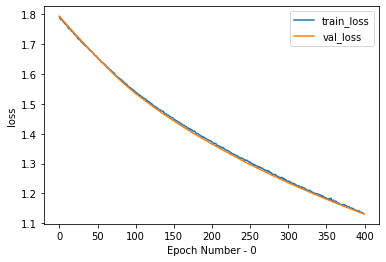

In [ ]:
PlotHistory(transfer_model_history, 'loss')

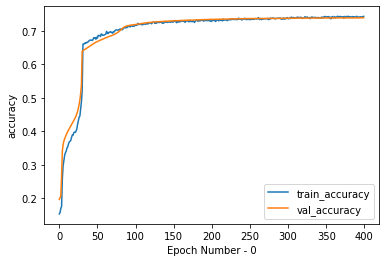

In [ ]:
PlotHistory(transfer_model_history, 'loss')

In [ ]:
pred_test_f3 = transfer_model_unet.predict(x_train_f3)
print(pred_test_f3.shape)
pred_mask_f3 = tf.argmax(pred_test_f3, axis=-1)
  # # pred_mask becomes [IMG_SIZE, IMG_SIZE]
  # # but matplotlib needs [IMG_SIZE, IMG_SIZE, 1]
pred_mask_f3 = tf.expand_dims(pred_mask_f3, axis=-1)
print(pred_mask_f3.shape)

(32, 128, 128, 7)
(32, 128, 128, 1)


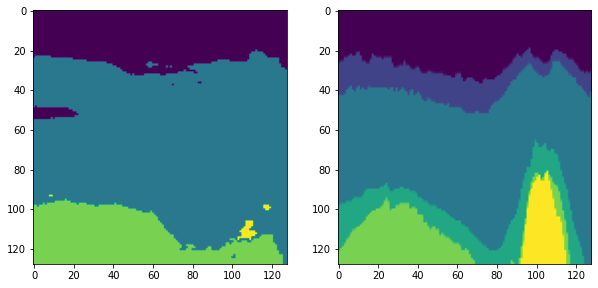

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,8))

ax[0].imshow(pred_mask_f3[4, :, :, 0])
ax[0].set_xlabel('X (km)')
ax[0].set_ylabel('Time (s)')
ax[0].set_title('Predicted Facies')
ax[1].imshow(y_train_f3[4, :, :])
ax[1].set_xlabel('X (km)')
ax[1].set_ylabel('Time (s)')
ax[1].set_title('Predicted Facies')
fig.suptitle('Transfer Learning Prediction with Training (Netherlands F3)')

# Now knowing the information from the Parihaka is overbearing in the transfer learning, we need to fine tune with transfer learning

In [28]:
base_model = tf.keras.models.load_model('/content/drive/MyDrive/Dataset /fixed_model_unet_1.h5')

In [29]:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

0 input_1
1 conv2d
2 batch_normalization
3 conv2d_1
4 batch_normalization_1
5 activation
6 max_pooling2d
7 dropout
8 conv2d_2
9 batch_normalization_2
10 conv2d_3
11 batch_normalization_3
12 activation_1
13 max_pooling2d_1
14 dropout_1
15 conv2d_4
16 batch_normalization_4
17 conv2d_5
18 batch_normalization_5
19 activation_2
20 max_pooling2d_2
21 dropout_2
22 conv2d_6
23 batch_normalization_6
24 conv2d_7
25 batch_normalization_7
26 activation_3
27 max_pooling2d_3
28 dropout_3
29 conv2d_8
30 batch_normalization_8
31 conv2d_9
32 batch_normalization_9
33 activation_4
34 up_sampling2d
35 conv2d_10
36 concatenate
37 dropout_4
38 conv2d_11
39 batch_normalization_10
40 conv2d_12
41 batch_normalization_11
42 activation_5
43 up_sampling2d_1
44 conv2d_13
45 concatenate_1
46 dropout_5
47 conv2d_14
48 batch_normalization_12
49 conv2d_15
50 batch_normalization_13
51 activation_6
52 up_sampling2d_2
53 conv2d_16
54 concatenate_2
55 dropout_6
56 conv2d_17
57 batch_normalization_14
58 conv2d_18
59 batch_

In [66]:
for layer in base_model.layers[:44]:
   layer.trainable = False
for layer in base_model.layers[44:]:
   layer.trainable = True

In [67]:
N_CLASSES_F3 = 7
transfer_out = base_model.output
transfer_out = tf.keras.layers.Conv2D(N_CLASSES_F3, 1, activation = 'softmax', name='transfer')(transfer_out)

In [68]:
transfer_model_unet = tf.keras.Model(inputs=base_model.input, outputs=transfer_out)

In [69]:
def dice_coef(y_true, y_pred, smooth=1e-7):
    '''
    Dice coefficient for 10 categories. Ignores background pixel label 0
    Pass to model as metric during compile statement
    '''
    y_true_f = K.flatten(K.one_hot(K.cast(y_true, 'int32'), num_classes=7))
    y_pred_f = K.flatten(y_pred)
    intersect = K.sum(y_true_f * y_pred_f, axis=-1)
    denom = K.sum(y_true_f + y_pred_f, axis=-1)
    return K.mean((2. * intersect / (denom + smooth)))

def PlotHistory(_model, feature, start_epoch = 0, path_file = None):
    val = "val_" + feature
    
    plt.xlabel('Epoch Number - ' + str(start_epoch))
    plt.ylabel(feature)
    plt.plot(_model.history[feature][start_epoch:])
    plt.plot(_model.history[val][start_epoch:])
    plt.title(val)
    plt.legend(["train_"+feature, val])   

In [70]:
initial_learning_rate = 0.1
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=200,
    decay_rate=0.96,
    staircase=True)

transfer_model_unet.compile(optimizer=Adam(learning_rate=lr_schedule), loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy', dice_coef])

#x_split, x_test_f3, y_split, y_test_f3 = train_test_split(training_img_data_f3, training_label_data_f3,test_size=0.985, shuffle= False) #take out of the bunch of the data
x_train_f3, x_test_f3_throw, y_train_f3, y_test_f3_throw = train_test_split(training_img_data_f3, training_label_data_f3,test_size=0.935, shuffle= True) #take out of the bunch of the data

#x_train_f3, x_val_f3_throw, y_train_f3, y_val_f3_throw = train_test_split(x_split, y_split, test_size=0, shuffle= False) # split train and validation 

x_val_f3, x_test_f3, y_val_f3, y_test_f3 = train_test_split(test1_img_data_f3, test1_label_data_f3,test_size=0.985, shuffle= True) #take out of the bunch of the data

Text(0.5, 1.0, 'True Facies (Labels)')

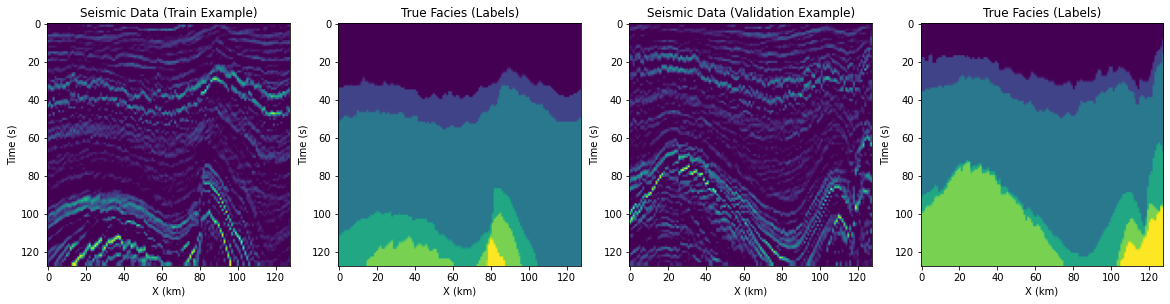

In [71]:
fig, ax = plt.subplots(1,4, figsize=(20,20))

ax[0].imshow(x_train_f3[4, :, :, 0])
ax[0].set_xlabel('X (km)')
ax[0].set_ylabel('Time (s)')
ax[0].set_title('Seismic Data (Train Example)')
ax[1].imshow(y_train_f3[4, :, :])
ax[1].set_xlabel('X (km)')
ax[1].set_ylabel('Time (s)')
ax[1].set_title('True Facies (Labels)')
ax[2].imshow(x_val_f3[1, :, :, 0])
ax[2].set_xlabel('X (km)')
ax[2].set_ylabel('Time (s)')
ax[2].set_title('Seismic Data (Validation Example)')
ax[3].imshow(y_val_f3[1, :, :])
ax[3].set_xlabel('X (km)')
ax[3].set_ylabel('Time (s)')
ax[3].set_title('True Facies (Labels)')

In [72]:
x_val_f3.shape
x_train_f3.shape

(26, 128, 128, 3)

In [73]:
model_path_transfer = "{}.h5".format('fixed_model_unet_1_transfer_tuned_1') #hdf5
checkpoint = ModelCheckpoint(model_path_transfer, monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_weights_only = False)

In [74]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_images=True, update_freq='batch')

transfer_model_history = transfer_model_unet.fit(x_train_f3, y_train_f3, validation_data=(x_val_f3, y_val_f3), epochs=63, callbacks=[tensorboard_callback])
#transfer_model_history = transfer_model_unet.fit(datagen_f3.flow(x_train_f3, y_train_f3), validation_data=(x_val_f3, y_val_f3), epochs=150, callbacks=[tensorboard_callback])

Epoch 1/63
1/1 [==============================] - 8s 8s/step - loss: 1.9508 - accuracy: 0.0000e+00 - dice_coef: 0.1435 - val_loss: 1.8282 - val_accuracy: 0.1829 - val_dice_coef: 0.1732
Epoch 2/63
1/1 [==============================] - 5s 5s/step - loss: 1.7586 - accuracy: 5.8688e-05 - dice_coef: 0.1759 - val_loss: 1.7485 - val_accuracy: 0.0516 - val_dice_coef: 0.1948
Epoch 3/63
1/1 [==============================] - 5s 5s/step - loss: 1.5839 - accuracy: 0.0495 - dice_coef: 0.2138 - val_loss: 1.6557 - val_accuracy: 0.4451 - val_dice_coef: 0.2238
Epoch 4/63
1/1 [==============================] - 5s 5s/step - loss: 1.4096 - accuracy: 0.7370 - dice_coef: 0.2618 - val_loss: 1.5505 - val_accuracy: 0.6239 - val_dice_coef: 0.2662
Epoch 5/63
1/1 [==============================] - 5s 5s/step - loss: 1.2749 - accuracy: 0.7479 - dice_coef: 0.3088 - val_loss: 1.4644 - val_accuracy: 0.6233 - val_dice_coef: 0.3063
Epoch 6/63
1/1 [==============================] - 5s 5s/step - loss: 1.1572 - accuracy:

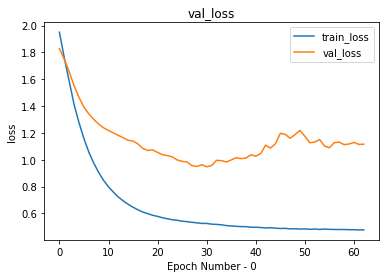

In [83]:
PlotHistory(transfer_model_history, 'loss')

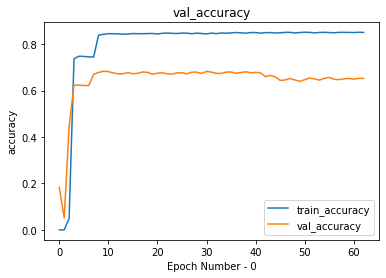

In [84]:
PlotHistory(transfer_model_history, 'accuracy')

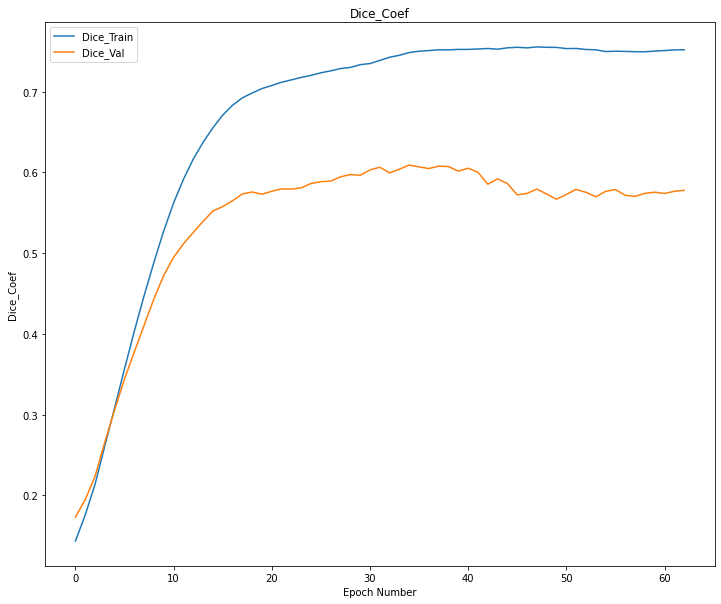

In [85]:
plt.figure(figsize=(12,10))
plt.xlabel('Epoch Number')
plt.ylabel('Dice_Coef')
plt.plot(transfer_model_history.history['dice_coef'])
plt.plot(transfer_model_history.history['val_dice_coef'])
plt.title('Dice_Coef')
plt.legend(["Dice_Train", "Dice_Val"])   
plt.show()

In [86]:
pred_train_f3 = transfer_model_unet.predict(x_train_f3)
print(pred_train_f3.shape)
pred_mask_f3 = tf.argmax(pred_train_f3, axis=-1)
  # # pred_mask becomes [IMG_SIZE, IMG_SIZE]
  # # but matplotlib needs [IMG_SIZE, IMG_SIZE, 1]
pred_mask_f3 = tf.expand_dims(pred_mask_f3, axis=-1)
print(pred_mask_f3.shape)

(26, 128, 128, 7)
(26, 128, 128, 1)


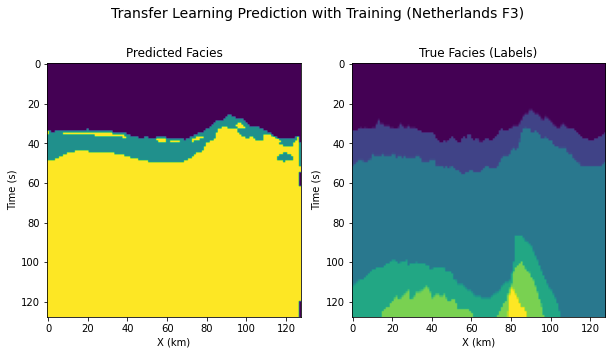

In [87]:
fig, ax = plt.subplots(1,2, figsize=(10,8))

ax[0].imshow(pred_mask_f3[4, :, :, 0])
ax[0].set_xlabel('X (km)')
ax[0].set_ylabel('Time (s)')
ax[0].set_title('Predicted Facies')
ax[1].imshow(y_train_f3[4, :, :])
ax[1].set_xlabel('X (km)')
ax[1].set_ylabel('Time (s)')
ax[1].set_title('True Facies (Labels)')
fig.suptitle('Transfer Learning Prediction with Training (Netherlands F3)', fontsize=14, y=0.82)
plt.show()

In [88]:
pred_test_f3 = transfer_model_unet.predict(x_test_f3)
print(pred_test_f3.shape)
pred_mask_f3_test = tf.argmax(pred_test_f3, axis=-1)
  # # pred_mask becomes [IMG_SIZE, IMG_SIZE]
  # # but matplotlib needs [IMG_SIZE, IMG_SIZE, 1]
pred_mask_f3_test = tf.expand_dims(pred_mask_f3_test, axis=-1)
print(pred_mask_f3_test.shape)

(197, 128, 128, 7)
(197, 128, 128, 1)


In [89]:
transfer_model_unet.evaluate(x=x_test_f3, y=y_test_f3, callbacks=[tensorboard_callback])

7/7 [==============================] - 1s 81ms/step - loss: 1.0595 - accuracy: 0.6665 - dice_coef: 0.5908


[1.0594979524612427, 0.6664636135101318, 0.5907506346702576]

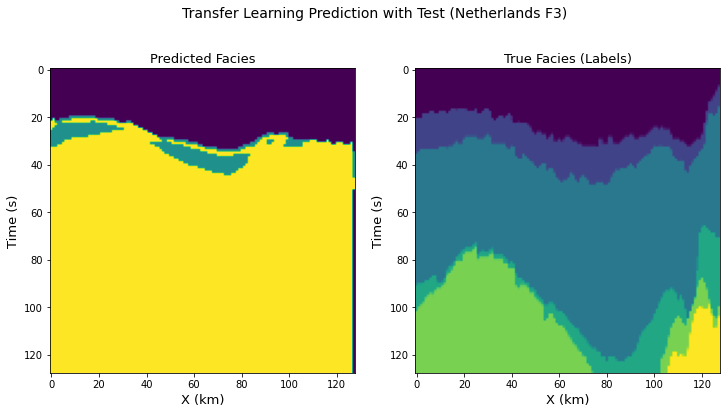

In [90]:
fig, ax = plt.subplots(1,2, figsize=(12,12))

ax[0].imshow(pred_mask_f3_test[8, :, :, 0])
ax[0].set_xlabel('X (km)', fontsize=13)
ax[0].set_ylabel('Time (s)', fontsize=13)
ax[0].set_title('Predicted Facies', fontsize=13)
ax[1].imshow(y_test_f3[8, :, :])
ax[1].set_xlabel('X (km)', fontsize=13)
ax[1].set_ylabel('Time (s)', fontsize=13)
ax[1].set_title('True Facies (Labels)', fontsize=13)
fig.suptitle('Transfer Learning Prediction with Test (Netherlands F3)', fontsize=14, y=0.75)
plt.show()